In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import sklearn.model_selection as model_selection

#os.chdir('/content/drive/MyDrive/BMI260/BMI260_project')
os.chdir('/content/drive/MyDrive/Spring 2022/BMI 260/BMI260_project')
PATH_TO_DATA = "MRNet-v1.0"

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import cv2

In [ ]:
#!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/metadata.csv

In [ ]:
os.chdir("MRNet")

In [ ]:
import argparse
from evaluate import *

def cam(split, model_path, diagnosis, plane, use_gpu):
  model, params, preds, labels = evaluate_for_cam(split, model_path, diagnosis, plane, use_gpu)
  return model, params, preds, labels
#Sagittal
model, params, preds, labels = cam("test", "../experiments/sagittal_models_5.17.2022/val0.1485_train0.0466_epoch13", 0, "sagittal", False)

# Axial
#model, params, preds, labels = cam("test", "../experiments/axial_models_5.17.2022/val0.1328_train0.0486_epoch13", 0, "axial", False)

# Coronal
#model, params, preds, labels = cam("test", "../experiments/coronal_models_5.17.2022/val0.1209_train0.0553_epoch20", 0, "sagittal", False)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

test loss: 0.1934
test AUC: 0.9318


In [ ]:
mod = nn.Sequential(*list(model.model.features.children())[:-1])

In [ ]:
# Image Preprocessing: 
### LOAD IMAGE ###
vol = np.load("../MRNet-v1.0/train/sagittal/0049.npy").astype(np.int32)
print(vol.shape)

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

# crop middle
pad = int((vol.shape[2] - INPUT_DIM)/2)
vol = vol[:,pad:-pad,pad:-pad]
print(vol.shape)
# standardize
vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol)) * MAX_PIXEL_VAL

# normalize
vol = (vol - MEAN) / STDDEV

# convert to RGB
vol = np.stack((vol,)*3, axis=1) 
print(vol.shape)

# part of preprocessing the images
vol_tensor = torch.FloatTensor(vol)
vol_variable = Variable(vol_tensor)

(32, 256, 256)
(32, 224, 224)
(32, 3, 224, 224)


In [ ]:
# return CAM upsamples the feature map to 256 x 256, multiples with the weight of the class to get the heatmap
def return_CAM(feature_conv, weight, class_idx):
    weight = [weight, 1-weight]
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    feature_conv = feature_conv[0]
    output_cam = []
    for idx in class_idx:
      beforeDot =  feature_conv.reshape((nc, h*w))
      cam = np.matmul(weight[idx], beforeDot)
      cam = cam.reshape(h, w)
      cam = cam - np.min(cam)
      cam_img = cam / np.max(cam)
      cam_img = np.uint8(255 * cam_img)
      output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
weight = np.squeeze(params[-2].data.numpy())

logit = model(vol_variable)
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()

features_blobs = mod(vol_variable)
features_blobs1 = features_blobs.cpu().detach().numpy() # detatch.numpy is how to get an array in torch
CAMs = return_CAM(features_blobs1, weight, [idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


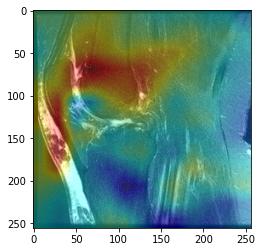

In [ ]:
import cv2
image = np.load("../MRNet-v1.0/train/sagittal/0049.npy")
height, width = image[18].shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)), cv2.COLORMAP_JET)
image_stacked = np.stack((image[18], image[18], image[18]), axis = 2)
result = heatmap/255*0.4 + image_stacked/255*0.7

plt.imshow(result)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# CAM
!python MRNet/cam.py --split test --diagnosis 0 --plane "sagittal" --model_path experiments/sagittal_models_5.17.2022/val0.1485_train0.0466_epoch13 --use_gpu False

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.1934
test AUC: 0.9318
Traceback (most recent call last):
  File "MRNet/cam.py", line 22, in <module>
    cam(args.split, args.model_path, args.diagnosis, args.plane, False)
  File "MRNet/cam.py", line 17, in cam
    plot_model(model)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/vis_utils.py", line 410, in plot_model
    if not model.built:
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1186, in __getattr__
    type(self).__name__, name))
AttributeError: 'MRNet' object has no att

In [ ]:
!python MRNet/train.py --rundir "experiments" --plane "axial" --diagnosis 0 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
starting epoch 1. time passed: 0:00:00.000515
train loss: 0.2056
train AUC: 0.6074
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
valid

In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "axial" --model_path experiments/axial_models_5.17.2022/val0.1905_train0.2056_epoch1 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.3080
test AUC: 0.8154


In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "axial" --model_path experiments/axial_models_5.17.2022/val0.1806_train0.1764_epoch2 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.2859
test AUC: 0.8586


In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "axial" --model_path experiments/axial_models_5.17.2022/val0.1672_train0.1520_epoch3 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.2718
test AUC: 0.8886


In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "axial" --model_path experiments/axial_models_5.17.2022/val0.1512_train0.1338_epoch4 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.2342
test AUC: 0.9018


In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "axial" --model_path experiments/axial_models_5.17.2022/val0.1439_train0.1050_epoch6 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.2105
test AUC: 0.9150


In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "axial" --model_path experiments/axial_models_5.17.2022/val0.1328_train0.0486_epoch13 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.1850
test AUC: 0.9430


In [ ]:
!python MRNet/train.py --rundir "experiments" --plane "coronal" --diagnosis 0 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
starting epoch 1. time passed: 0:00:00.000466
train loss: 0.2080
train AUC: 0.5920
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
valid

In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "coronal" --model_path experiments/coronal_models_5.17.2022/val0.1209_train0.0553_epoch20 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.2412
test AUC: 0.8666


In [ ]:
!python MRNet/train.py --rundir "experiments" --plane "sagittal" --diagnosis 0 --gpu

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
starting epoch 1. time passed: 0:00:00.000520
train loss: 0.2063
train AUC: 0.6008
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
valid

In [ ]:
!python MRNet/evaluate.py --split test --diagnosis 0 --plane "sagittal" --model_path experiments/sagittal_models_5.17.2022/val0.1485_train0.0466_epoch13 --gpu 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
test loss: 0.1934
test AUC: 0.9318
